In [351]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

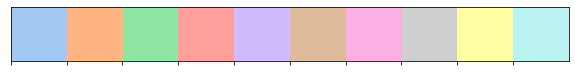

In [352]:
# importing dependencies
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import re
import random
palette = sns.color_palette("pastel")
sns.palplot(palette)

In [353]:
# setting pandas properties to view all the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [354]:
# reading the data set
data = pd.read_csv('loan.csv')
# as we will be analysing only the default and fully paid values, so we drop rows containing information on current borrowers
data = data[data['loan_status']!='Current']
print("Shape of the data frame: ",data.shape)

Shape of the data frame:  (38577, 111)


D:\Softwares\Anaconda_Installation\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.



### Cleaning the data

##### Handling Missing Values

Shape Remains:  (38577, 49)
(38577, 44)


<AxesSubplot:>

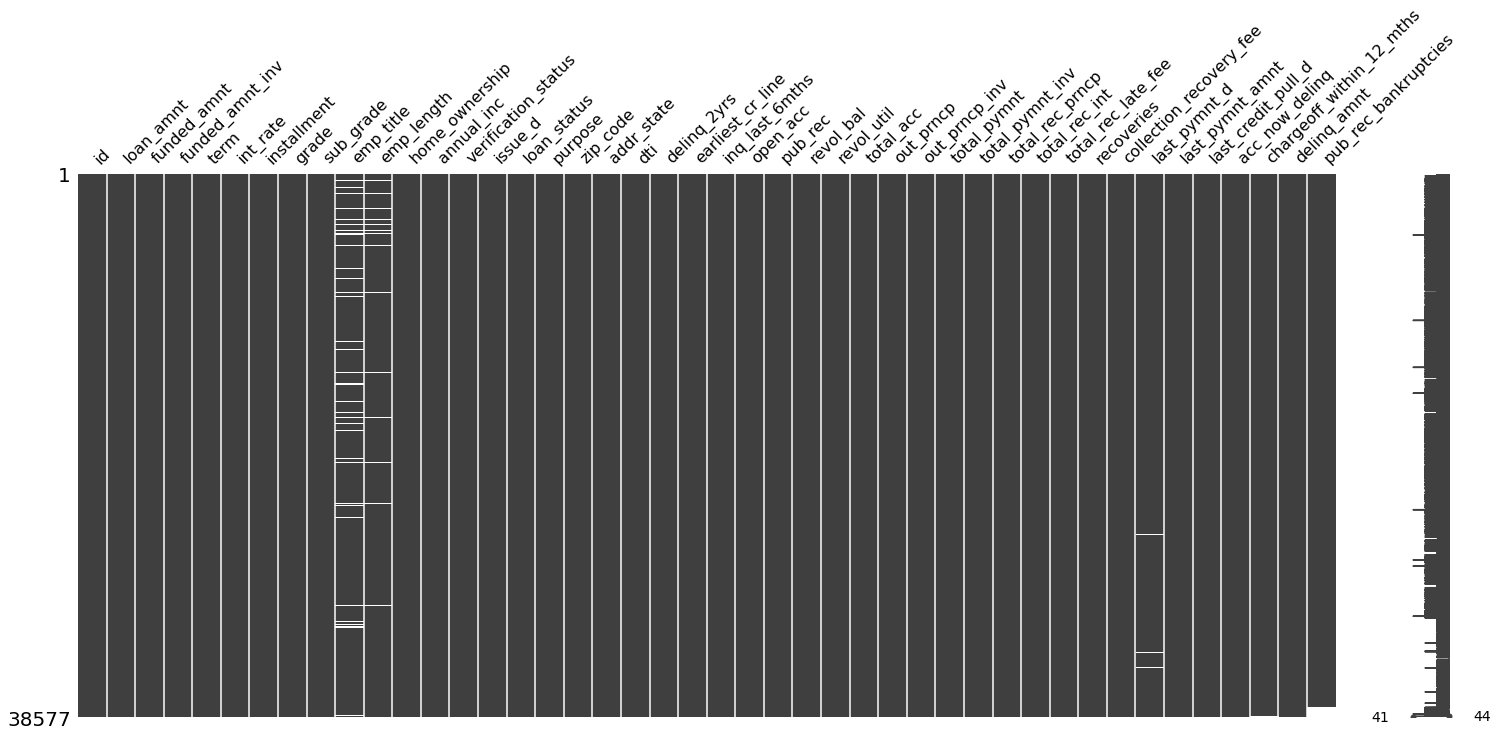

In [355]:
# as we observe alot of columns have all the values as None, hence these are of no use to us for analysis 
# we drop these columns
data = data.dropna(axis=1, how='all')
# also we plan on dropping the following columns for the below mentioned reasons
# url -> there is no information we can get from URLs, urls have the loan is's which we already have in the dataset
# tax_liens -> All the values here are 0's or either NA's, so this cannot be a factor for rejection or approval of loan
# pymnt_plan -> All the values are 'n' here, so this cannot be a factor for reject or approval of loan
# policy_code -> all values are '1' here
# initial_list_status -> all values are 'f' here
# collections_12_mths_ex_med -> all are individual borrowers
# application_type -> all values are 0's or NA's
data = data.drop(['url','tax_liens','pymnt_plan','policy_code','initial_list_status','collections_12_mths_ex_med','application_type'],axis=1)
print("Shape Remains: ",data.shape)
# we still have columns which contain nulls
data = data.drop(['title','desc','mths_since_last_delinq','mths_since_last_record'],axis=1)
# we do not need id and member_id columns so we can drop these as well
data.drop(['member_id'], axis=1, inplace=True)
print(data.shape)
### Let us again check how many columns still have NA values left
msno.matrix(data)

columns having more than 100% 0 as values: ['out_prncp', 'out_prncp_inv', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt']
(38577, 39)


<AxesSubplot:>

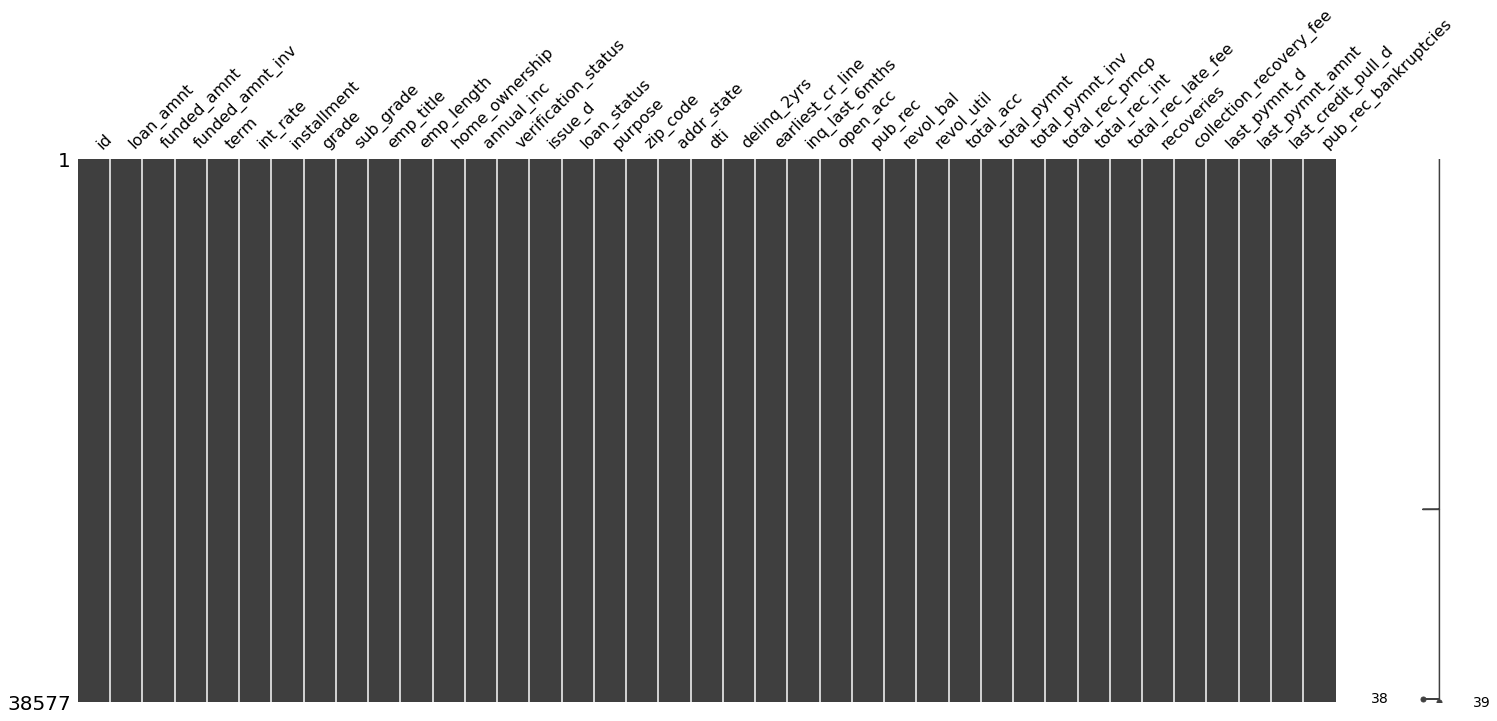

In [356]:
### Let us handle the few null values we are left with
data.emp_title.fillna('Not Specified', inplace=True) # as we do not know the actual value and imputing values could cause problems
data.revol_util.fillna(0, inplace=True)
data.pub_rec_bankruptcies.fillna(0.0, inplace=True)
data.last_pymnt_d.fillna('last amount not paid', inplace=True) # last amount was not paid due to which the loan was charged off
# handling emp_length, we convert these strings to numbers first and then fill na values by random numbers ranging 0-10.
data.emp_length.fillna(random.randint(1,10), inplace=True)
data.emp_length = data.emp_length.astype(str)
data['emp_length'] = [re.sub("[^0-9]", "", i) for i in data['emp_length']]
# handling empty values in chargeoff_within_12_mths
data['chargeoff_within_12_mths'].fillna(0.0, inplace=True)
# there are still some columns which has to be deleted as all the values in those columns are coming out to be '0'
# below logic is written to remove columns where we have more than 100% 0's
cols = data.columns
cols_to_be_dropped = []
for i in cols:
    percent_0 = round(len(data[i][data[i]==0])/len(data[i])*100,2)
    if percent_0 >= 100:
        cols_to_be_dropped.append(i)
print('columns having more than 100% 0 as values:',cols_to_be_dropped)
data = data.drop(cols_to_be_dropped, axis=1)
print(data.shape)
### now after filing in all the na values we again check for nulls
msno.matrix(data)

In [357]:
### we have few columns which are available to us only after the loan is approved, but we need to consider only the attributes
### which are available at the time when a user applies for a loan. so we drop such columns
data.drop(['installment','earliest_cr_line','total_pymnt','total_pymnt_inv','total_rec_int',
          'total_rec_late_fee','total_rec_prncp','recoveries','collection_recovery_fee','last_pymnt_d',
          'last_pymnt_amnt','last_credit_pull_d'], axis=1, inplace=True)
data.shape

(38577, 27)

#### Handling Column Data Types and Conducting Sanity Checks

In [358]:
# we need to make some hygiene changes to the data set
# Convert int_rate to float
data['int_rate'] = [i[:-1] for i in data['int_rate']]
data['int_rate'] = data['int_rate'].astype(float) 
# Convert revol_util to foat
data['revol_util'] = data.revol_util.astype(str)
data['revol_util'] = [re.sub("[^0-9,.]", "", i) for i in data['revol_util']]
data['revol_util'] = data['revol_util'].astype(float)
# Convert term to int
data['term'] = [re.sub("[^0-9]", "", i) for i in data['term']]
data['term'] = data['term'].astype(int)
# Convert emp_length to int
data['emp_length'] = data['emp_length'].astype(int)

In [359]:
# let us standardize emp_title text values (upper case)
data.emp_title = data.emp_title.str.upper()

In [360]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
0,1077501,5000,5000,4975.0,36,10.65,B,B2,NOT SPECIFIED,10,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,860xx,AZ,27.65,0,1,3,0,13648,83.7,9,0.0
1,1077430,2500,2500,2500.0,60,15.27,C,C4,RYDER,1,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,309xx,GA,1.00,0,5,3,0,1687,9.4,4,0.0
2,1077175,2400,2400,2400.0,36,15.96,C,C5,NOT SPECIFIED,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,606xx,IL,8.72,0,2,2,0,2956,98.5,10,0.0
3,1076863,10000,10000,10000.0,36,13.49,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,917xx,CA,20.00,0,1,10,0,5598,21.0,37,0.0
5,1075269,5000,5000,5000.0,36,7.90,A,A4,VEOLIA TRANSPORTATON,3,RENT,36000.0,Source Verified,Dec-11,Fully Paid,wedding,852xx,AZ,11.20,0,3,9,0,7963,28.3,12,0.0


<ipython-input-361-f27de4a9f214>:8: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



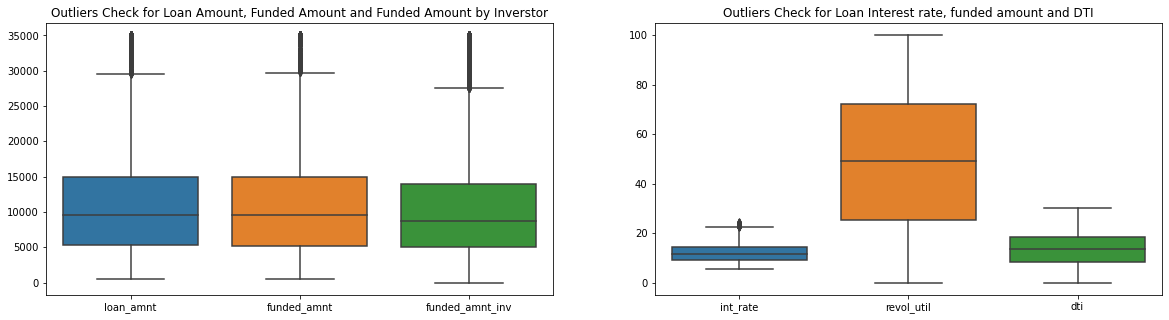

In [361]:
### We are left with only 26 columns now narrowing down our analysis, let us alos have a look at the outliers in our numerical
### columns and we will impute those values to the nearest value i.e by upperbound and lowerbounds
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(data=data[['loan_amnt','funded_amnt','funded_amnt_inv']], ax=ax0)
ax0.set_title('Outliers Check for Loan Amount, Funded Amount and Funded Amount by Inverstor')
sns.boxplot(data=data[['int_rate','revol_util','dti']], ax=ax1)
ax1.set_title('Outliers Check for Loan Interest rate, funded amount and DTI')
fig.show()

<ipython-input-362-0db3225d0d29>:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

<ipython-input-362-0db3225d0d29>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



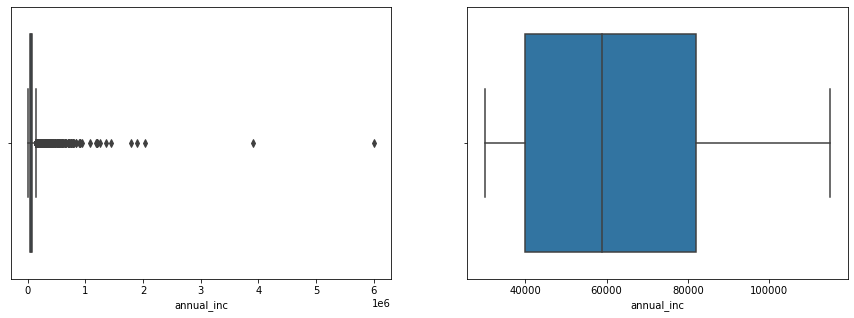

In [362]:
f, (ax0,ax1) = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(x=data.annual_inc,data=data,ax=ax0)
# ax1.title('Annual income Column before Outlier Removal')
f.show()
# as we see there are too many outliers in the annual_income, let us handle it with flooring and capping method
per_10th = data['annual_inc'].quantile(0.10)
per_90th = data['annual_inc'].quantile(0.90)
data["annual_inc"] = np.where(data["annual_inc"] <per_10th, per_10th,data['annual_inc'])
data["annual_inc"] = np.where(data["annual_inc"] >per_90th, per_90th,data['annual_inc'])
# let us again check if the outliers are handled
sns.boxplot(x=data.annual_inc,data=data, ax=ax1)
f.show()

as we see there are no outliers present in the annual_income column now, and for the other columns there are a few outliers but those are not extreme values, so we can leave those as it is

We have handled the missing values of data set in a way which <b>does not result into loss of data</b>
Moving on to sanity checks we will have to take care of some of the columns data types and the values it contains before we move on to Analysis of the dataset

In [363]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    38577 non-null  int64  
 1   loan_amnt             38577 non-null  int64  
 2   funded_amnt           38577 non-null  int64  
 3   funded_amnt_inv       38577 non-null  float64
 4   term                  38577 non-null  int32  
 5   int_rate              38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   sub_grade             38577 non-null  object 
 8   emp_title             38577 non-null  object 
 9   emp_length            38577 non-null  int32  
 10  home_ownership        38577 non-null  object 
 11  annual_inc            38577 non-null  float64
 12  verification_status   38577 non-null  object 
 13  issue_d               38577 non-null  object 
 14  loan_status           38577 non-null  object 
 15  purpose            

### We have checked for Data types and also have handled the missing values, now we can move on to analysis of the data.

In [364]:
data.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
count,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000
mean,6.763787e+05,11047.025430,10784.058506,10222.481123,41.898437,11.932219,5.059414,63735.735494,13.272727,0.146668,0.871737,9.275423,0.055422,13289.489826,48.639653,22.052648,0.042694
std,2.092639e+05,7348.441646,7090.306027,7022.720644,10.333136,3.691327,3.355909,27269.043715,6.673044,0.492271,1.071546,4.401588,0.237804,15866.492241,28.400460,11.425861,0.202809
min,5.473400e+04,500.000000,500.000000,0.000000,36.000000,5.420000,1.000000,30000.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,5.120330e+05,5300.000000,5200.000000,5000.000000,36.000000,8.940000,2.000000,40000.000000,8.130000,0.000000,0.000000,6.000000,0.000000,3650.000000,25.100000,13.000000,0.000000
50%,6.564230e+05,9600.000000,9550.000000,8733.440000,36.000000,11.710000,4.000000,58868.000000,13.370000,0.000000,1.000000,9.000000,0.000000,8762.000000,49.000000,20.000000,0.000000
75%,8.291460e+05,15000.000000,15000.000000,14000.000000,36.000000,14.380000,9.000000,82000.000000,18.560000,0.000000,1.000000,12.000000,0.000000,16912.000000,72.200000,29.000000,0.000000
max,1.077501e+06,35000.000000,35000.000000,35000.000000,60.000000,24.400000,10.000000,115000.000000,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,2.000000


<ipython-input-365-10ece52a7dd8>:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



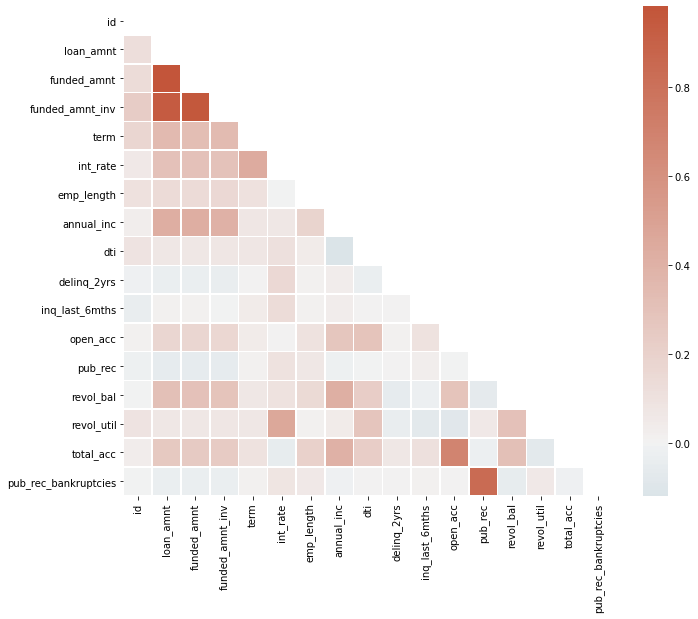

In [365]:
# let us look at the correation matrix of the data
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5)
f.show()

* We have very high positive correlation among loan amount, funded amount and investor amount we can safely assume that the behavioural pattern of these columns is the same.
* We have another high positive correlation between public deragatory account and public recent bankrupticies.
* there are many columns which look independent of each other as the correlation is near 0 for lot of columns.

<ipython-input-384-e12a191d04ed>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



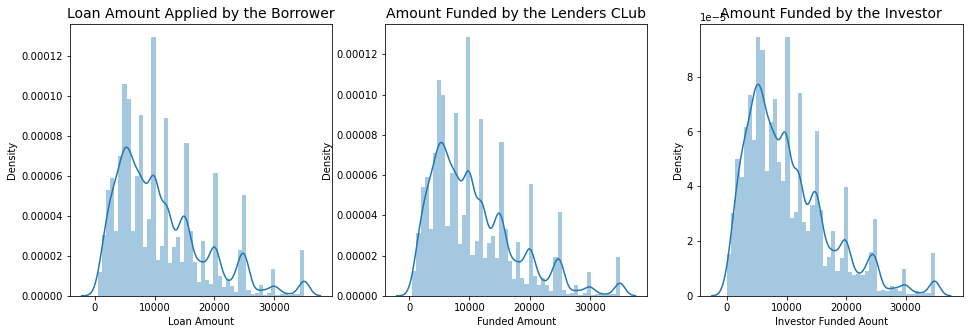

In [384]:
# let us look at the distributions of loan amount, amount funded by thr leanding club and amount invested by the investor
fig, ax = plt.subplots(1, 3, figsize=(16,5))
sns.distplot(data["loan_amnt"], ax=ax[0])
ax[0].set_title("Loan Amount Applied by the Borrower", fontsize=14)
ax[0].set(xlabel="Loan Amount")
sns.distplot(data['funded_amnt'] , ax=ax[1])
ax[1].set_title("Amount Funded by the Lenders CLub", fontsize=14)
ax[1].set(xlabel="Funded Amount")
sns.distplot(data["funded_amnt_inv"], ax=ax[2])
ax[2].set_title("Amount Funded by the Investor", fontsize=14)
ax[2].set(xlabel="Investor Funded Aount")
fig.show()

we see a left skew in all the cases, we also observe that the pattern is similar in all the cases and the most loan amounts funded fall between the bracket of 2000 to 10,000

### Analysis on the Time period

<ipython-input-413-68f457b8331d>:19: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



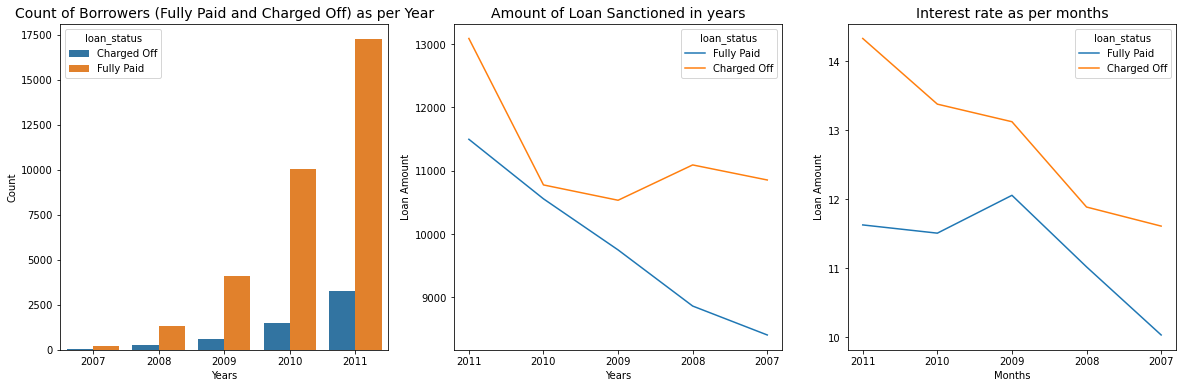

In [413]:
# let us have a look at the loan amounts issued as per years
data['issue_year'] = ['20'+i[4:] for i in data['issue_d']]
data['issue_month'] = [i[:3] for i in data['issue_d']]

# let us see in which year most people defaulted 
df = data[['issue_year','loan_status','id']].groupby(by=['issue_year','loan_status'], as_index=False).count()
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.barplot(x='issue_year',y='id',hue='loan_status',data=df, ax=ax[0])
ax[0].set_title("Count of Borrowers (Fully Paid and Charged Off) as per Year", fontsize=14)
ax[0].set(xlabel="Years", ylabel = "Count")
# amount of loan assigned as per years
sns.lineplot(x="issue_year", y="loan_amnt", data=data, ax=ax[1], hue='loan_status', ci=None)
ax[1].set_title("Amount of Loan Sanctioned in years", fontsize=14)
ax[1].set(xlabel="Years", ylabel = "Loan Amount")
# let us chekc whether in which month the highest amount of loans are sanctioned.
sns.lineplot(x='issue_year', y='int_rate', data=data, ax=ax[2], ci=None, hue="loan_status")
ax[2].set_title("Interest rate as per months", fontsize=14)
ax[2].set(xlabel="Years", ylabel = "Loan Amount")
fig.show()

### Following are the observations and findings from the data charts displayed above:
Chart 1:
* number of loans approved was highest for the year 2011.
* we have the highest number of defaulters in the year 2011, but also we have highest number of borrowers who cleared their loan in 2011
* we can see a trend growing from 2007 to 2011
    * there is an average of 30% increase in number of loan applicants every year.
    * the lending company has to be ready to serve a bigger population as the year passes by.
 
Chart 2:
* we observe that the amount of loan that was charged off was quite a lot when summed up compared to the oan that was paid. this also indicates that the company might have faced some big losses

Chart 3:
* we notice that there is a huge huge difference between the interest rates of fully paid and charged off customers.

### Analysis as per the Regions
let us now check borrowers from which region tend to default, also we can check in which region the interest rate or annual income is higher

In [368]:
# we have lots of states in the addr_states column, let us map it to regions which would be easier for us to do analysis
# to do the mapping we use the below data set
# link to the dataset -> https://www.kaggle.com/omer2040/usa-states-to-region
region_state_map = pd.read_csv('states.csv')
region_state_map = region_state_map[['State Code','Region']]
data = data.merge(region_state_map, left_on='addr_state', right_on='State Code', how='left')
data.drop('State Code', axis=1, inplace=True)

<ipython-input-390-9da137f1c3be>:22: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



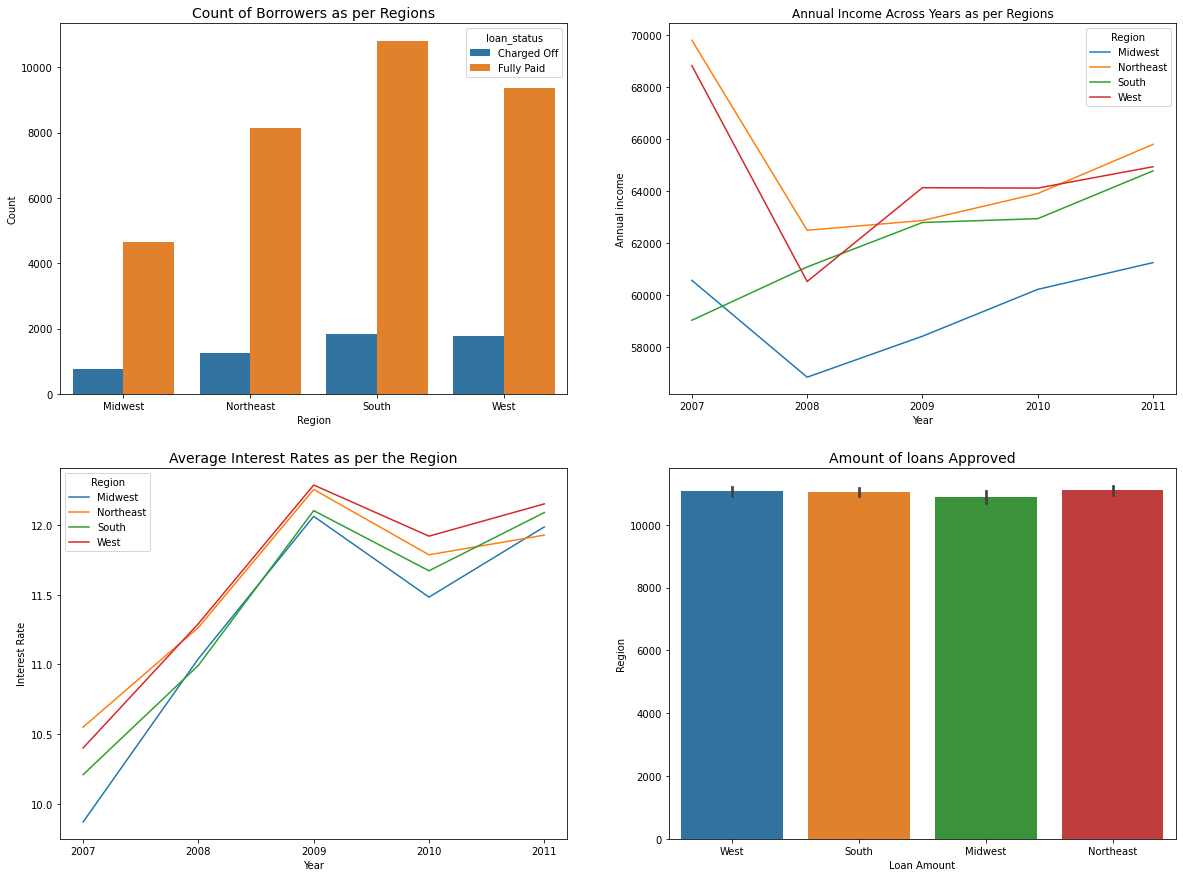

In [390]:
# plots
# number of defaulters as per the regions
df = data[['Region','loan_status','id']].groupby(by=['Region','loan_status'], as_index=False).count()
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize=(20,15))
sns.barplot(x='Region',y='id',hue='loan_status',data=df, ax=ax0)
ax0.set_title("Count of Borrowers as per Regions", fontsize=14)
ax0.set(xlabel="Region", ylabel = "Count")
# Average income as per the regions
df = data[['Region','issue_year','annual_inc']].groupby(['Region','issue_year'], as_index=False).mean()
sns.lineplot(data=df, x='issue_year',y='annual_inc',hue='Region', ax=ax1)
ax1.set_title("Annual Income Across Years as per Regions")
ax1.set(xlabel="Year", ylabel = "Annual income")
# Average interest rate as per the regions
df = data[['Region','int_rate','issue_year']].groupby(by=['Region','issue_year'], as_index=False).mean()
sns.lineplot(x='issue_year',y='int_rate',hue='Region',data=df, ax=ax2)
ax2.set_title("Average Interest Rates as per the Region", fontsize=14)
ax2.set(xlabel="Year", ylabel = "Interest Rate")
# Loan sanctioned as per the regions
sns.barplot(x='Region',y='loan_amnt',data=data, ax=ax3)
ax3.set_title("Amount of loans Approved", fontsize=14)
ax3.set(xlabel="Loan Amount", ylabel = "Region" )
fig.show()

In [370]:
print('Precentage of Defaulters in Every Region')
print('South',round(data[(data['Region']=='South')&(data['loan_status']=='Charged Off')].shape[0]/data[data['Region']=='South'].shape[0]*100,2))
print('West',round(data[(data['Region']=='West')&(data['loan_status']=='Charged Off')].shape[0]/data[data['Region']=='West'].shape[0]*100,2))
print('Mid West',round(data[(data['Region']=='Midwest')&(data['loan_status']=='Charged Off')].shape[0]/data[data['Region']=='Midwest'].shape[0]*100,2))
print('North East',round(data[(data['Region']=='Northeast')&(data['loan_status']=='Charged Off')].shape[0]/data[data['Region']=='Northeast'].shape[0]*100,2))

Precentage of Defaulters in Every Region
South 14.45
West 15.98
Mid West 14.03
North East 13.43


### Following are the insights and observations from the above charts
* In the first chart we see that the average annual income of west and south-east regions are the highest, so naturally defaulters should be less from these 2 regions right? but the percentage of defauters remain almost the same for all regions.
* We can find the reason for this in chart 3, we see that in regions where average income is high the interest rate is also high, which might cause the defauter rate to be the same across all regions.
* also in the last chart we can observe that the loan amount is equally distributed across regions 

### Analysis on Grades (Risk Assessment)

<ipython-input-371-0286c7627412>:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



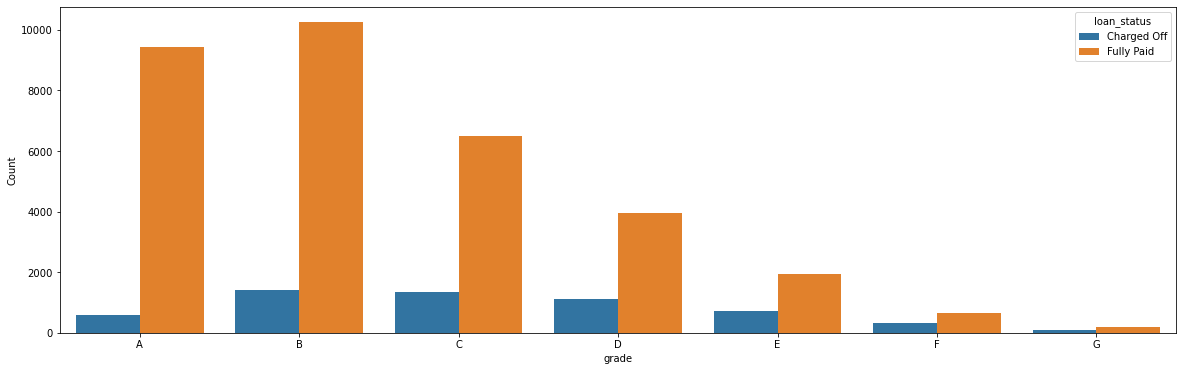

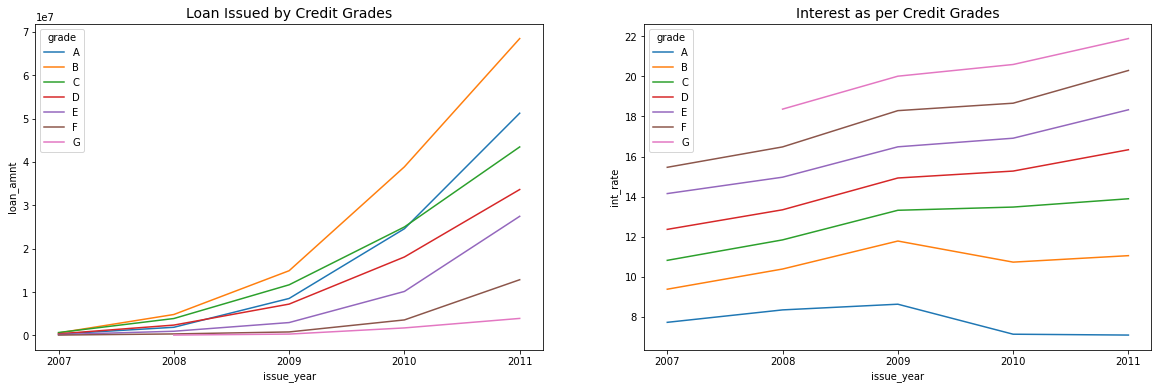

In [371]:
# grades as per loan status
df = data[['grade','loan_status','id']].groupby(['grade','loan_status'], as_index=False).count()
df.rename(columns={'id':'Count'}, inplace=True)
fig,ax=plt.subplots(1,1,figsize=(20,6))
fig = sns.barplot(data=df, x="grade", y="Count", hue="loan_status")
# loan issued as per credit grades
f, ax = plt.subplots(1,2, figsize=(20,6))
df = data[['issue_year','loan_amnt','grade']].groupby(by = ['grade','issue_year'],as_index=False).sum()
sns.lineplot(x='issue_year',y='loan_amnt',hue='grade',data=df, ax=ax[0])
ax[0].set_title("Loan Issued by Credit Grades", fontsize=14)
# interest rates as per the grades
df = data[['issue_year','int_rate','grade']].groupby(by = ['grade','issue_year'],as_index=False).mean()
sns.lineplot(x="issue_year", y='int_rate', hue='grade' , data=df, ax=ax[1])
ax[1].set_title("Interest as per Credit Grades", fontsize=14)
f.show()

### Observation
1. we see that the most number of loans were approved for gardes A, B and C.
2. as we go towards grades D, E, F and G we see that the deafult rate is increasing (chart 1)
3. over the years the loan amount approved for grade B has been the highest and we see that grades A and B enjoy low interest rates due to their grades.
4. low interest rates is one reason why the rate of defaulers is less in grades A, B and C
5. if you look at grade G, almost 50% of the population falls under defaulters list and high interest rates is one reason for that.

### Analysis for Employee Income

In [372]:
# let us first create a bucket for annual_income -> this will make analysing the data easy
def buckets(inc):
    if inc<=50000:
        return 'low'
    elif inc>50000 and inc<=90000:
        return 'medium'
    else:
        return 'high'            
data['income_category'] = data.annual_inc.apply(lambda x: buckets(x))

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Loan Amount')]

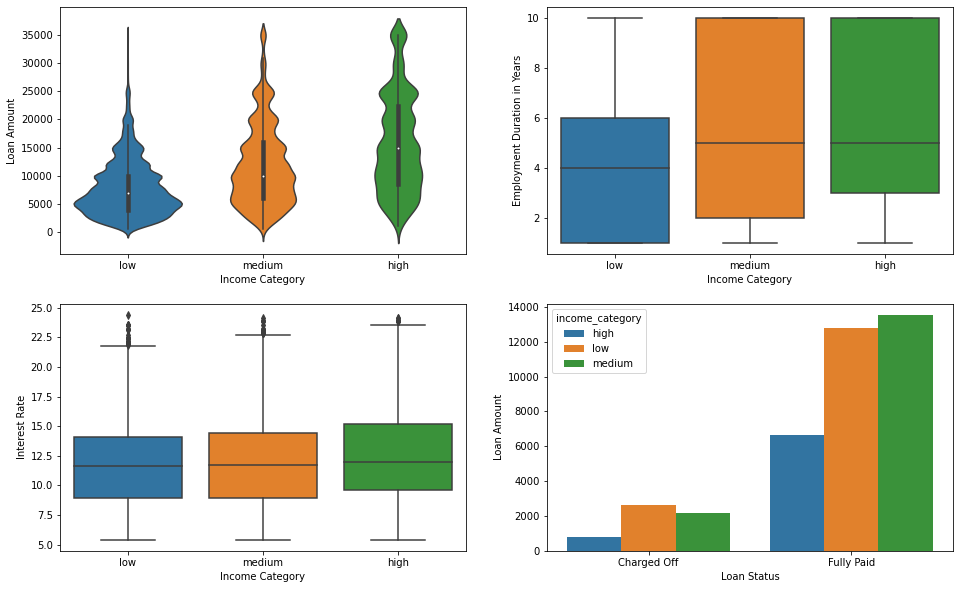

In [399]:
fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(nrows=2, ncols=2, figsize=(16,10))

sns.violinplot(x="income_category", y="loan_amnt", data=data, ax=ax1 )
ax1.set(xlabel='Income Category', ylabel='Loan Amount')
sns.boxplot(x="income_category", y="emp_length", data=data, ax=ax2)
ax2.set(xlabel='Income Category', ylabel='Employment Duration in Years')
sns.boxplot(x="income_category", y="int_rate", data=data, ax=ax3)
ax3.set(xlabel='Income Category', ylabel='Interest Rate')
df = data[['income_category','loan_amnt','loan_status']].groupby(['loan_status','income_category'], as_index=False).count()
sns.barplot(x="loan_status", y="loan_amnt", hue="income_category", data=df, ax=ax4, ci=None)
ax4.set(xlabel='Loan Status', ylabel='Loan Amount')

In [374]:
# let us also look at the buckets created below
pd.crosstab([data['grade'],data['loan_status']], columns=data['income_category']).style.background_gradient(axis=0)

### Observation
1. Chart 1 (loan amount distribution as per the income categories):
    We see that people with low income usually aply for loans below 10000USD and the people who fall under high income group tend to apply for loans uptil 35000.
2. Chart 2 (Employment Length ad per Income categories):
    People with low income has around 2-6 years of work experience where as people with medium and high income has around 3-10 years of work experience
3. Chart 3 (Interest Rates per Income Gorup):
    We observe that there is not much significant difference here in the interest rates of the income groups.
4. Chart 4 (Count of fully paid and charged off borrowers as per the income category):
    We see that the most number of defaulters are in the low income category (given their income is less and they do not enjoy any such )
5. in the cross table printed above we can see that among all the grades people with low incomes have defaulted the most!

### Analysis on  home_ownership

<ipython-input-375-5a47da6cd884>:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



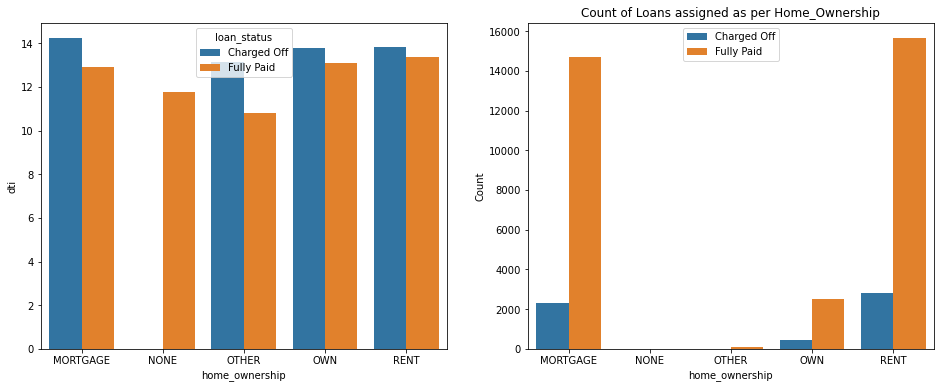

In [375]:
# home_ownership
fig, ((ax1, ax2))= plt.subplots(nrows=1, ncols=2, figsize=(16,6))
df = data[['home_ownership','loan_status','dti','loan_amnt']].groupby(['home_ownership','loan_status'], as_index=False).agg({'dti':'mean','loan_amnt':'sum'})
sns.barplot(data=df, x="home_ownership", y="dti", hue='loan_status', ax=ax1)
df = data[['home_ownership','loan_status','id']].groupby(['home_ownership','loan_status'], as_index=False).count()
df.rename(columns={'id':'Count'}, inplace=True)
sns.barplot(data=df, x="home_ownership", y="Count", hue="loan_status")
ax2.set_title('Count of Loans assigned as per Home_Ownership')
ax2.legend(loc='upper center')
fig.show()

### Observation
There is no significant difference in the DTI rate across the owners, but the people who rent and apartment or are on a mortgage tend to default more compared to other owners.

### Analysis on the Purpose of loan, Employment length

<ipython-input-400-4101ba605228>:13: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



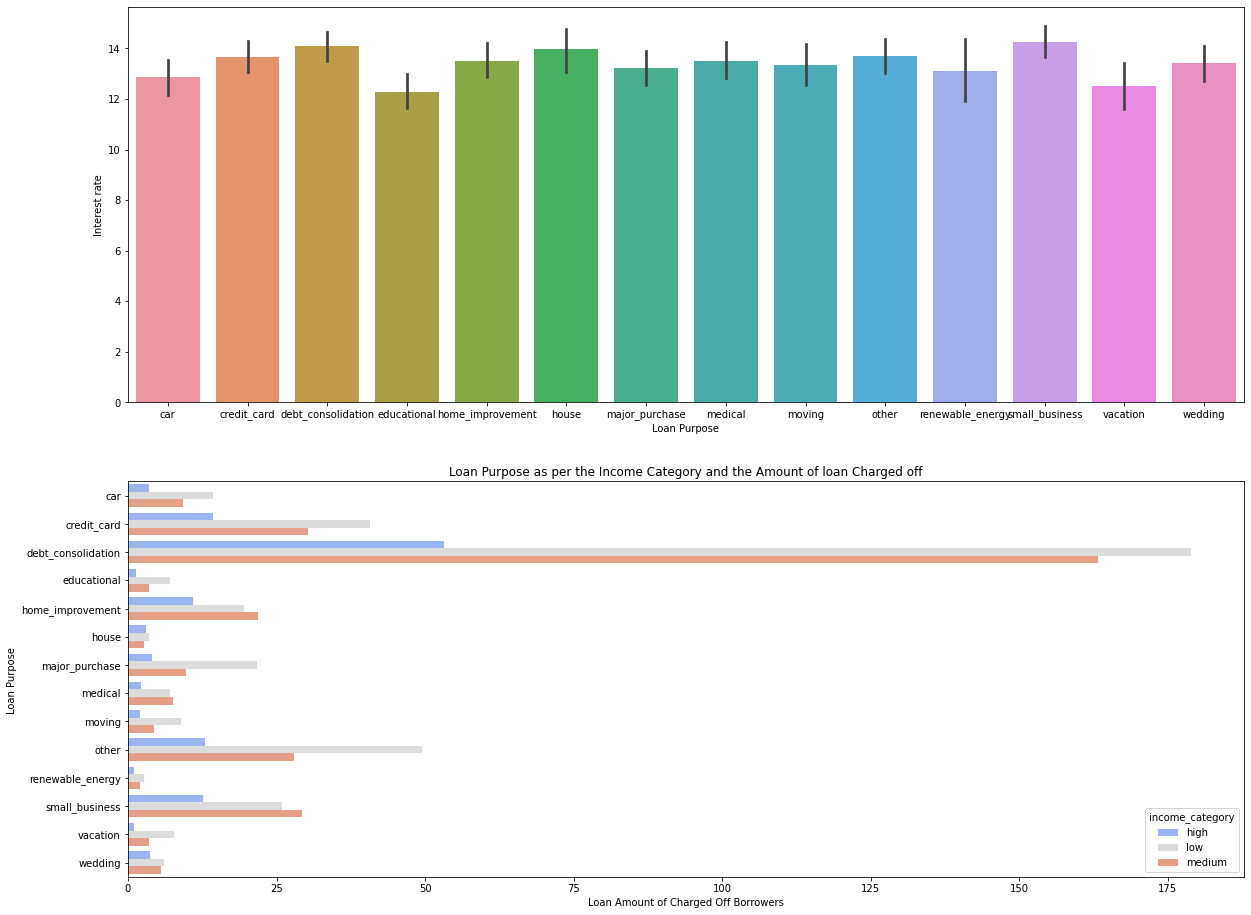

In [400]:
# Purpose and the loan status
df = data[['purpose','loan_status','id','issue_year','grade','loan_amnt','int_rate','income_category']].groupby(['purpose','loan_status','issue_year','grade','income_category'], as_index=False).agg({'id':'count', 'loan_amnt': 'sum', 'int_rate':'mean'})
df.rename(columns={"id":"Count"}, inplace=True)
fig, ((ax1, ax2))= plt.subplots(nrows=2, ncols=1, figsize=(20,16))
sns.barplot(data=df, x="purpose", y="int_rate", ax=ax1)
ax1.set(xlabel='Loan Purpose', ylabel='Interest rate')
# let us also check for the annual income and interest rate for each of the borrower
purpose_df = data[['purpose','int_rate','annual_inc','loan_amnt','dti','income_category','grade','loan_status']].groupby(['purpose','income_category','grade','loan_status'],as_index=False).count()
c = sns.color_palette("tab10")
sns.barplot(x='loan_amnt',y='purpose', hue='income_category',data=purpose_df[purpose_df['loan_status']=='Charged Off'], palette='coolwarm', ci=None, ax=ax2)
ax2.set_title('Loan Purpose as per the Income Category and the Amount of loan Charged off')
ax2.set(xlabel='Loan Amount of Charged Off Borrowers', ylabel='Loan Purpose ')
f.show()

### Observation
1. The First thing we observe that among all the loan purposes, highest loan application has been recieved and approved for debt consolodation. the interest rate of of debt consolidation loan is also higher compared to others.
2. In the second chart we Observe that the highest number of defaulters also belong ot the debt cosolidation group. the particular loan is oftenly asked by the borrowers who fall under low or medium income bracket.
3. We also see that loans for vacation, wedding, medical, house and education has less defaulters.
4. When offering loan for debt_consolidation the lenders should check if the user belong from high income bracket and also should make sure the borrower's credit score grade is atleast C.

### Analysis on DTI

<ipython-input-402-1e8b475a5128>:14: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



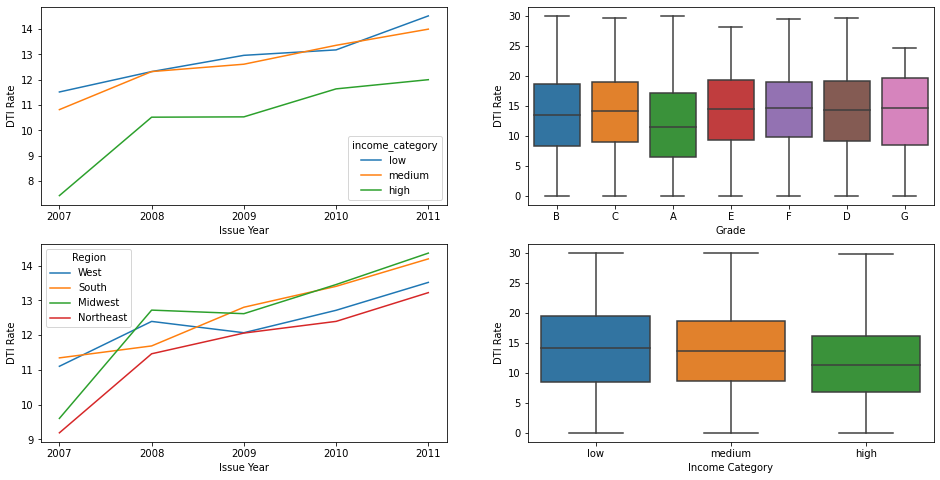

In [402]:
df = data[['issue_year','Region','dti','revol_util','grade','purpose','income_category','loan_amnt','loan_status']]
fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(nrows=2, ncols=2, figsize=(16,8))

sns.lineplot(x="issue_year", y="dti", hue="income_category", data=df, ax=ax1, ci=None)
ax1.invert_xaxis()
ax1.set(xlabel='Issue Year', ylabel='DTI Rate')
sns.boxplot(x="grade", y="dti", data=df, ax=ax2)
ax2.set(xlabel='Grade', ylabel='DTI Rate')
sns.lineplot(x="issue_year", y="dti", data=df, ax=ax3, hue='Region' , ci=None)
ax3.set(xlabel='Issue Year', ylabel='DTI Rate')
ax3.invert_xaxis()
sns.boxplot(x="income_category", y="dti", data=df, ax=ax4)
ax4.set(xlabel='Income Category', ylabel='DTI Rate')
fig.show()

### Observation
1. a high debt to income ratio is considered as a warning sing for the lenders or the investors when lending.
2. our 1st chart shows that the dti ratio of people with high income is too low compared to the dti ratio of the people with low and medium incomes
3. the dti rate is less for people in grade A and our earlier analysis on income group proved that people has a good credit score are generallly from high income bracket. but for other credit grade score the dti is almost similar.
4. the dti rate has been increasing over the years, and the people of northeast seem to have the best dti rate.

### Summary of All the Observations

In [378]:
# need to drop columns which are not availabe at the time of loan application, below analysis can be performed done
# impute outlier values to the min or max, identify outliers using IQR. done
# Analysis as per the regions done
# Analysis as per the purpose done
# Analysis as per the time period done
# Analysis of the loan status done
# Analysis as per the income or household done
# Analysis as per the dti and average_emp_length
# Analysis as per the grades done
# Which type of loan usually falls under default